In [214]:
# Import Libraries
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import csv
import datetime

# Importing statistics libraries
import statsmodels.api as sm
import scipy
from scipy import stats

#show plot in notebook
%matplotlib inline 

#limits amount of lines pandas prints out
from pandas import set_option 
set_option('display.max_rows', 10)

# Importing and Cleaning Data

In [216]:
#Loading the main dataset from excel into python, specified taking data from the 'Sales' sheet
Sales_df = pd.read_excel('../data/SalesDataA.xlsm', sheetname = 'Sales')
# Renaming the columns 
Sales_df.columns = [['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']]
Sales_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
0,NaN,ABB Australia,engine technology,2010-08-04,1897.60,NaN,Returning
1,NaN,A&A Metal Products,engine technology,2010-08-16,28963.00,NaN,Returning
2,NaN,Analytical Engineer.,engine technology,2010-08-20,76339.00,NaN,Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New


In [152]:
# Replacing the empty values in the Exchange Rate column with 1 and setting the index to Date_of_Order
Exchange_df= Sales_df[['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']].replace([None], [1]).set_index('Date_of_Order')
# Creating a new column in the data set, which puts all sales amounts in Canadian dollars. 
Exchange_df['Sales_in_CAD'] = Exchange_df['Exchange_Rate'] * Exchange_df['Total_Sales']
Exchange_df.head()

,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
Date_of_Order,,,,,,,
2010-08-04,1,ABB Australia,engine technology,1897.60,1,Returning,1897.60
2010-08-16,1,A&A Metal Products,engine technology,28963.00,1,Returning,28963.00
2010-08-20,1,Analytical Engineer.,engine technology,76339.00,1,Returning,76339.00
2010-08-27,1,Bombardier Inc.,aerospace,24318.92,1,New,24318.92
2010-09-15,1,Beef Products Inc.,food,35084.00,1,New,35084.00


The reason why the empty exchange rate values are replaced with 1 is because for these dates the exchange rate between Canadian and US dollars was basically 1, so the person entering the data did not bother writing in a value. 

In [153]:
# Creating a new dataframe that includes all values with the Sales in CAD 
# All rows with dates under 2012-07-31 will be deleted
Change_New = Exchange_df[Exchange_df.index > '2012-07-31'].reset_index()
Change_New.head()

,Date_of_Order,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
0,2012-08-01,1,Powerspan Corp.,alternative energy,11165.00,1,Returning,11165.00
1,2012-08-01,1,Multi Pression,solutions provider,1924.68,1,Returning,1924.68
2,2012-08-02,1,A&A Metal Products,engine technology,8765.00,1,Returning,8765.00
3,2012-08-03,1,Fluid Controls LTD,distributor,27750.00,1,New,27750.00
4,2012-08-07,1,ASM America,material science,170882.00,2012-05-01 00:00:00,Returning,170882.00


The reason why I deleted all rows before 2012-08-01, is because this data is not accurate (some of it is not sorted by month).  

# PLOT 1: Resampling data to make a plot that compares money spent on ads per month to sales coming from new customers & number of new customers.

In [154]:
# Deleting all rows of sales from returning customers
New_customers = Change_New.groupby(['New_or_Returning']).get_group('New')
New_customers.head()

,Date_of_Order,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
3,2012-08-03,1,Fluid Controls LTD,distributor,27750.00,1,New,27750.00
5,2012-08-08,1,Pomerleau,construction,916.12,1,New,916.12
7,2012-08-13,1,LightSail Energy,alternative energy,4389.00,1,New,4389.00
10,2012-08-24,1,Siati Espress,other,12854.40,2012-08-01 00:00:00,New,12854.40
17,2012-09-07,1,Greater Moncton,research,2144.10,1,New,2144.10


In [155]:
# Grabbing 3 columns from the dataset and setting the index to Date of order.
Resampled_ind = New_customers[['Date_of_Order', 'Total_Sales', 'New_or_Returning']].set_index('Date_of_Order')
Resampled_ind.head()

,Total_Sales,New_or_Returning
Date_of_Order,,
2012-08-03,27750.00,New
2012-08-08,916.12,New
2012-08-13,4389.00,New
2012-08-24,12854.40,New
2012-09-07,2144.10,New


In [156]:
# Replacing the 'New' string with the number 1 so that they can be added later. 
# And data is downsampled to month, taking the sum of the Sales and the new customers in each month. 
Index_Month= Resampled_ind[['New_or_Returning', 'Total_Sales']].replace(['New'], [1]).resample('M', how=('sum')) 
Index_Month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2012-08-31,4,45909.52
2012-09-30,1,2144.10
2012-10-31,4,18763.53
2012-11-30,5,24919.22
2012-12-31,1,3278.00


In [157]:
# Deleting all rows that have a date before 2013-08-31. Keeping only two business years 2013 - 2015. The reason why I dont 
# want data before this date, is because the Date input in the dataset was incomplete for the previous years.
Downsampled_month = Index_Month[Index_Month.index > '2013-08-30']
Downsampled_month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2013-08-31,3,7410.00
2013-09-30,4,13538.40
2013-10-31,5,9627.02
2013-11-30,10,40999.01
2013-12-31,5,35721.00


# Importing a new dataset (Cost of Ads per month)

In [158]:
#Loading another dataset from excel into python from a different sheet, and making the Date column the index.
Ads_df = pd.read_excel('../data/SalesDataA.xlsm', sheetname = 'Ads', index_col='Date')
Ads_df.head()

,Ad Cost
Date,
2013-08-01,947.94
2013-09-01,936.06
2013-10-01,935.72
2013-11-01,930.47
2013-12-01,948.00


In [159]:
# Renaming the column
# Resampling the date column, so that the month is synonymous with the other table 
Ads_df.columns = ['Ad_Cost']
Ads_df = Ads_df.resample('M', how=('sum'))   
Ads_df.head()

,Ad_Cost
Date,
2013-08-31,947.94
2013-09-30,936.06
2013-10-31,935.72
2013-11-30,930.47
2013-12-31,948.00


In [160]:
# Combining the two dataframes by the date of order, and resetting the index.
Combined_df = pd.concat([Downsampled_month, Ads_df], axis=1, join_axes=[Downsampled_month.index]).reset_index()
Combined_df.head()

,Date_of_Order,New_or_Returning,Total_Sales,Ad_Cost
0,2013-08-31,3,7410.00,947.94
1,2013-09-30,4,13538.40,936.06
2,2013-10-31,5,9627.02,935.72
3,2013-11-30,10,40999.01,930.47
4,2013-12-31,5,35721.00,948.00


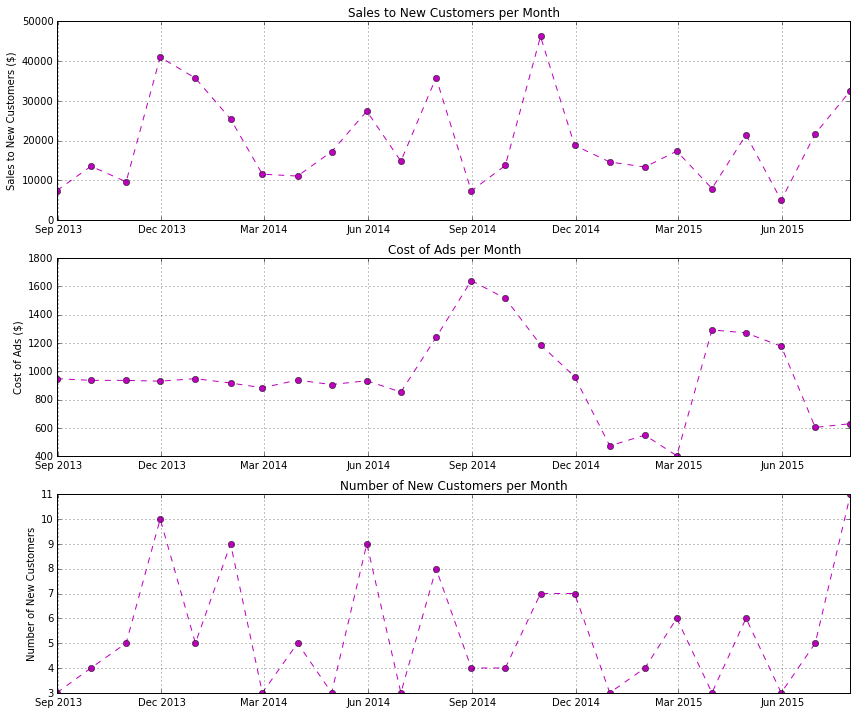

In [161]:
#change figure size
plt.figure(figsize=(12,10)) # in inches, width then height. 

#creating subplots and defining them
# 3 rows, 1 columns, 1st subplot
plt.subplot(3,1,1)      
plt.plot(Combined_df.Date_of_Order, Combined_df.Total_Sales, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales to New Customers per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales to New Customers ($)')

# 3 rows, 1 columns, 2nd subplot
plt.subplot(3,1,2)      
plt.plot(Combined_df.Date_of_Order, Combined_df.Ad_Cost, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Cost of Ads per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Cost of Ads ($)')

# 3 rows, 1 columns, 3rd subplot
plt.subplot(3,1,3)      
plt.plot(Combined_df.Date_of_Order, Combined_df.New_or_Returning, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Number of New Customers per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Number of New Customers')

# give plots some breathing room
plt.tight_layout()

#show plot
plt.show()



C:\Users\mim\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


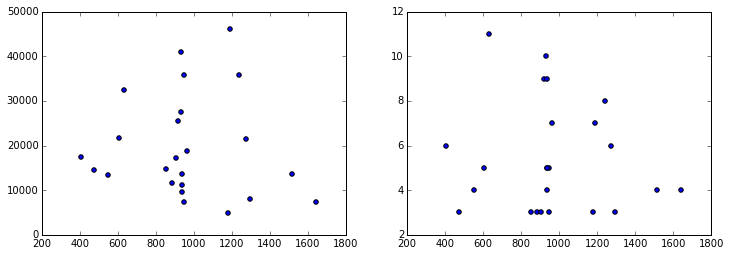

In [378]:
# Creating plots that compare cost of ads to Sales and Numeber of new customers. 
plt.figure(figsize=(12,4))

#Subplot 1
plt.subplot(1,2,1)
plt.scatter(Combined_df.Ad_Cost, Combined_df.Total_Sales)

#Subplot 2 
plt.subplot(1,2,2)
plt.scatter(Combined_df.Ad_Cost, Combined_df.New_or_Returning)

#PLOT 2: Plotting the distribution of sales over the years 2013- 2015 by month (Instead of plotting Sales, could plot the number of customers too). 

In [162]:
# Visualizing the dataframe that we will downsample to make plot 2 
#Dates_df.head()

In [243]:
# Grabbing 3 columns from a previous dataset and setting the index to Date of order
# Resampling the index column (Dates) by month, taking the sum of the Sales in each month.
Month_df = Change_New[['Date_of_Order', 'New_or_Returning', 'Sales_in_CAD']].set_index('Date_of_Order').resample('M', how=('sum'))
                                                                                                             

In [244]:
# Deleting all rows before 2012-08-31. Keeping only 3 business years 2012 - 2015. 
df_less = Month_df[Index_Month.index > '2012-08-30']
df_less.head()

,Sales_in_CAD
Date_of_Order,
2012-08-31,266208.49
2012-09-30,242972.33
2012-10-31,78000.68
2012-11-30,165319.22
2012-12-31,8561.60


Making 3 different tables to have one table per business year from 2013-2015. Make a function for this so you dont have to repeat the same thing 3 times!

In [165]:
# Making a table for the business year 2014-2015 only
Year3_df = df_less.drop(df_less.index[:24]).reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year3_df['Month'] = Year3_df['Date_of_Order'].dt.month
Year3_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2014-08-31,31362.196600,8
1,2014-09-30,139844.239100,9
2,2014-10-31,166207.229360,10
3,2014-11-30,66069.594558,11
4,2014-12-31,85777.469182,12


In [166]:
def month_name (df):
    '''Writes out the month number as a string'''
    with open (df, 'r') as mydf:
        # This reads the lines in the dataframe
        file = mydf.readlines()
        
        if mydf['Month'] == 8 :
            return 'Aug'
        if mydf['Month'] == 9 :
            return 'Sep'
        if mydf['Month'] == 10 :
            return 'Oct'
        if mydf['Month'] == 11 :
            return 'Nov'
        if mydf['Month'] == 12 :
            return 'Dec' 
        if mydf['Month'] == 1 :
            return 'Jan' 
        if mydf['Month'] == 2 :
            return 'Feb' 
        if mydf['Month'] == 3 :
            return 'Mar' 
        if mydf['Month'] == 4 :
            return 'Apr' 
        if mydf['Month'] == 5 :
            return 'May' 
        if mydf['Month'] == 6 :
            return 'June' 
        if mydf['Month'] == 7 :
            return 'July'

In [168]:
#month_name(Year3_df)

In [169]:
# Uses the function above to create a new column from the Year3_df dataframe. 
Year3 = Year3_df.apply(lambda row: month_name (row),axis=1)

TypeError: ("Can't convert 'Series' object to str implicitly", 'occurred at index 0')

In [170]:
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year3_df, Year3], axis=1, join_axes=[Year3.index]).reset_index()
Combined_Month.columns = [['index', 'Date_of_Order', 'Sales_in_CAD', 'Month', 'Month_str']]
Combined_Month.head()

NameError: name 'Year3' is not defined

In [171]:
# Making a table for the business year 2012-2013 only
Year1_df = df_less.drop(df_less.index[12:]).reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year1_df['Month'] = Year1_df['Date_of_Order'].dt.month
Year1_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2012-08-31,266208.49,8
1,2012-09-30,242972.33,9
2,2012-10-31,78000.68,10
3,2012-11-30,165319.22,11
4,2012-12-31,8561.60,12


In [172]:
Year1 = Year1_df.apply(lambda row: month_name (row),axis=1)
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year1_df, Year1], axis=1, join_axes=[Year1.index]).reset_index()
Combined_Month.head()

TypeError: ("Can't convert 'Series' object to str implicitly", 'occurred at index 0')

In [173]:
# Making a table for the business year 2013-2014 only
Year2_df = df_less.iloc[12:24].reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year2_df['Month'] = Year2_df['Date_of_Order'].dt.month
Year2_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2013-08-31,81819.96200,8
1,2013-09-30,58372.19460,9
2,2013-10-31,113018.98208,10
3,2013-11-30,104607.67808,11
4,2013-12-31,82281.35900,12


In [365]:
Year2 = Year2_df.apply (lambda row: month_name (row),axis=1)
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year2_df, Year2], axis=1, join_axes=[Year2.index]).reset_index()
Combined_Month.head()

TypeError: ("Can't convert 'Series' object to str implicitly", 'occurred at index 0')

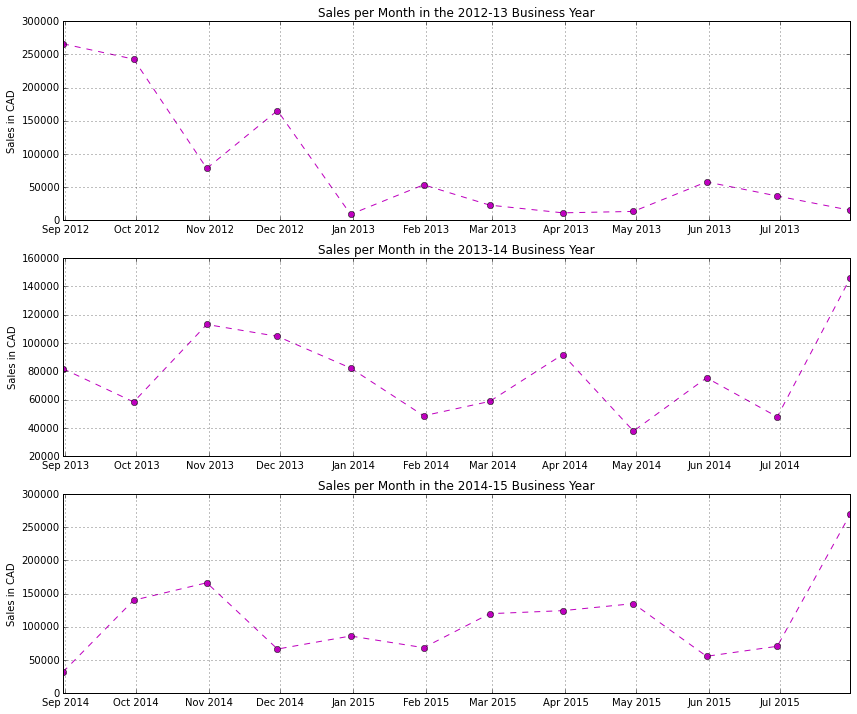

In [175]:
#change figure size
plt.figure(figsize=(12,10)) # in inches, width then height. 

#creating subplots and defining them
# 3 rows, 1 columns, 1st subplot
plt.subplot(3,1,1)      
plt.plot(Year1_df.Date_of_Order, Year1_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2012-13 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# 3 rows, 1 columns, 2nd subplot
plt.subplot(3,1,2)      
plt.plot(Year2_df.Date_of_Order, Year2_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2013-14 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# 3 rows, 1 columns, 3rd subplot
plt.subplot(3,1,3)      
plt.plot(Year3_df.Date_of_Order, Year3_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2014-15 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# give plots some breathing room
plt.tight_layout()

#show plot
plt.show()

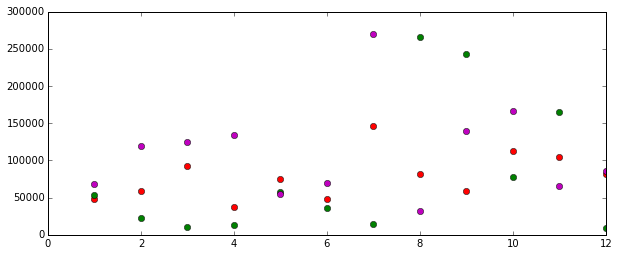

In [176]:
#Plotting all 3 subplots in the same plot as a scatter plot
plt.figure(figsize=(10,4))
plt.plot(Year2_df.Month, Year2_df.Sales_in_CAD, 'ro', Year2_df.Month, Year1_df.Sales_in_CAD, 'go', Year1_df.Month, Year3_df.Sales_in_CAD, 'mo')

#PLOT3: Creating a boxplot that shows the distribution of sales across all fields, also showing how large individual Sales were. This will be done for all years combined first. 

In [221]:
# Groupby Field and Sales_in_CAD to keep each sales order seperate so we can later plot a boxplot which shows
# the distribution of sales. 
resampled_groups = Exchange_df.groupby(['Field', 'Sales_in_CAD']).sum()
resampled_groups.head()

Exchange_Rate  Total_Sales
Field     Sales_in_CAD                            
aerospace 124.5840             1.0740          116
          235.5885             1.2465          189
          505.0000             1.0000          505
          559.7100             1.2438          450
          1410.1620            1.0740         1313

In [178]:
# Resetting the index columns in order to plot 
resampled1_groups = resampled_groups.reset_index()

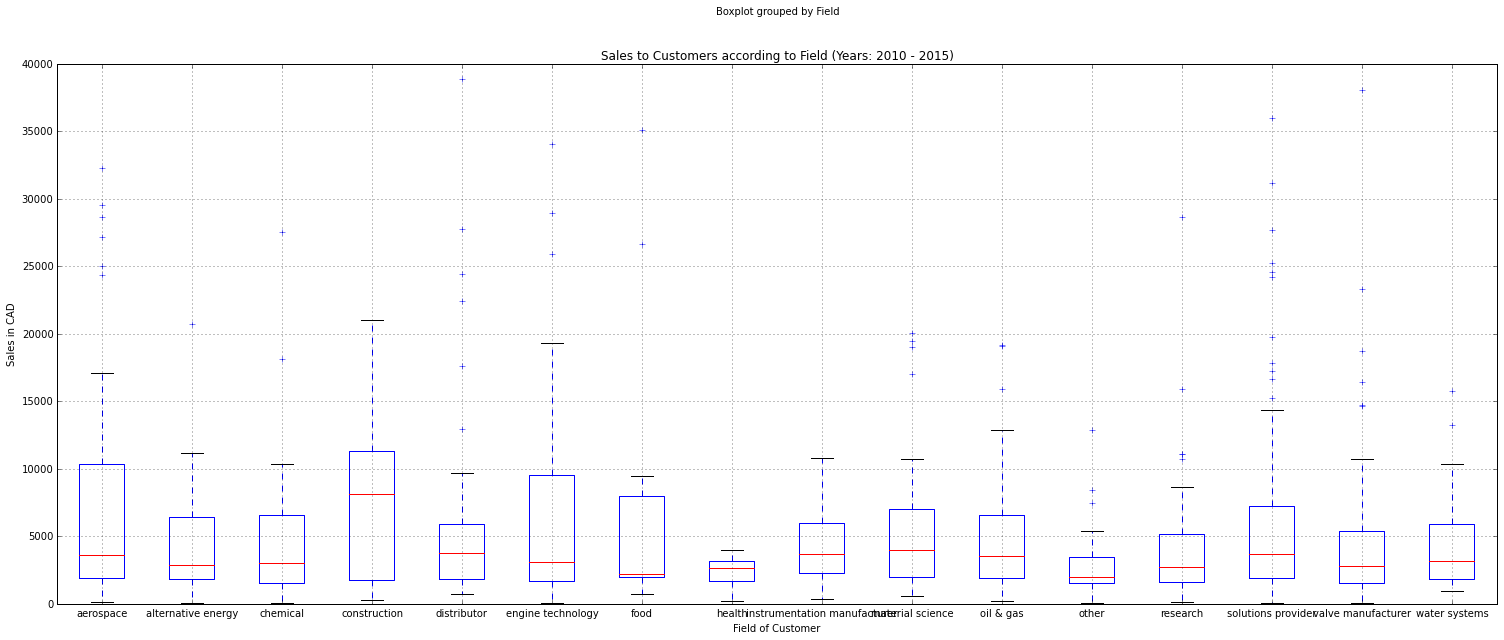

In [179]:
#Creating a boxplot of Sales according to the field a customer works in. This plot is for all years (2010 - 2015) combined
resampled1_groups.boxplot(by = 'Field', column='Sales_in_CAD', figsize=(25,10))

#Changing the y limit
plt.ylim(0, 40000)

plt.title('Sales to Customers according to Field (Years: 2010 - 2015)')
plt.xlabel('Field of Customer')
plt.ylabel('Sales in CAD')


Now I am trying to seperate each string in the Field column to create seperate plots, that will show the difference in sales in each years to see if there are any visible trends in any fields over the years. I would like to use a function for this to make it most efficient. 


In [251]:
# Creating a new table that contains only the columns that we need to create seperate plots for each field
Reset_ind = Exchange_df.reset_index()
Fields_df = Reset_ind[['Date_of_Order', 'Field', 'New_or_Returning', 'Sales_in_CAD']]
Fields_df.head()

,Date_of_Order,Field,New_or_Returning,Sales_in_CAD
0,2010-08-04,engine technology,Returning,1897.60
1,2010-08-16,engine technology,Returning,28963.00
2,2010-08-20,engine technology,Returning,76339.00
3,2010-08-27,aerospace,New,24318.92
4,2010-09-15,food,New,35084.00


In [252]:
# Trying to downsample data to business year, but it downsamples to year. 
Aerospace_an = aerospace_df.resample('BA', how=('sum'))  

In [226]:
# Creating a variable that contains all the names of the fields in the Field column
Fields = ['aerospace', 'oil & gas', 'alternative energy', 'engine technology', 'construction', 'research', 'water systems', 'distributor', 'solutions provider', 'other', 'instrumentation manufacturer', 'valve manufacturer', 'material science', 'chemical', 'food', 'health']

In [268]:
# Creating a dictionary that will contain each field seperately, so you can call each field with the dictionary
dic = {}

# Creating a FOR loop that will groupby a specified field in the field column of a dataframe.
for field in Fields:
    dic[field] = Fields_df.groupby(['Field']).get_group(field)

In [264]:
# Creating a variable for each field
research_df = dic['research']
oilgas_df = dic['oil & gas']
alternative_df = dic['alternative energy']


In [357]:
# Defining a function that will plot from a dataframe. The function takes in the two columns from a dataframe,
# that will be plotted on the x and y axis. 
def plot(x, y):
    plt.figure(figsize=(10,3))
    plt.plot(x, y, marker='o', linewidth=0)
    plt.ylim(-1000,)

Now I am trying to find which fields are interesting to look at. Which fields show interesting trends/fluctuations in sales. I plotted all fields using the plot function, however i only kept the fields which showed an interesting trend. 

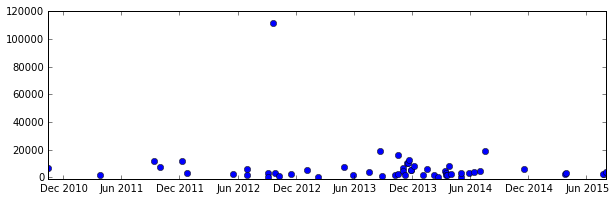

In [358]:
plot(dic['oil & gas']['Date_of_Order'], dic['oil & gas']['Sales_in_CAD'])

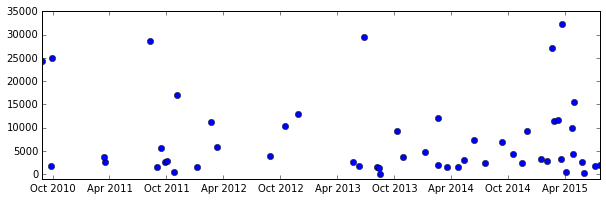

In [359]:
plot(dic['aerospace']['Date_of_Order'], dic['aerospace']['Sales_in_CAD'])

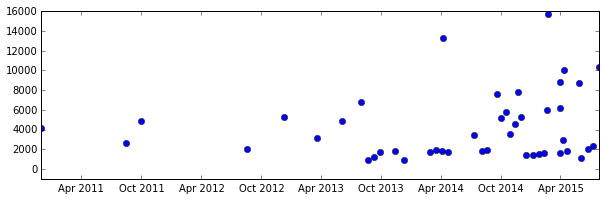

In [360]:
plot(dic['water systems']['Date_of_Order'], dic['water systems']['Sales_in_CAD'])

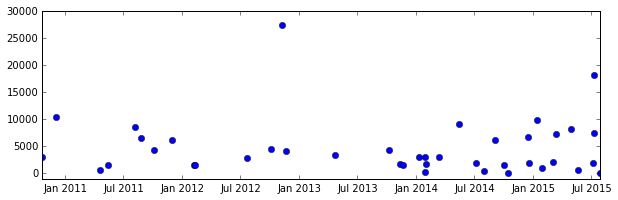

In [361]:
plot(dic['chemical']['Date_of_Order'], dic['chemical']['Sales_in_CAD'])

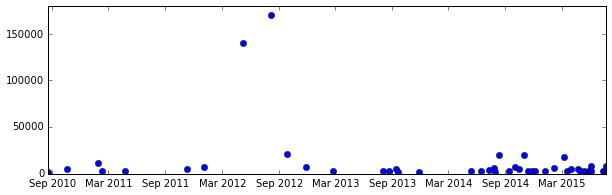

In [362]:
plot(dic['material science']['Date_of_Order'], dic['material science']['Sales_in_CAD'])

In [182]:
# Trying to make a function that takes out rows per business year from a dataframe
def businessyear(SalesData):
    '''Extracts all dates in a specific business year from a dataset,
    to create a new dataframe with just this year'''
    # Opening the data in the function
    # The r means read file
    with open (SalesData, 'r') as mySalesData:
        #Reading all of the lines in the dataframe
        file = mySalesData.readlines()
        
        # This creates a variable of the Date column
        dates = file.Date
        
        if dates == 2010:
            return ('You suck')

In [ ]:
def business(dataframe):

In [183]:
businessyear(Exchange_df)

TypeError: invalid file:                Exchange_Rate                      Customer  \
Date_of_Order                                                
2010-08-04                 1                 ABB Australia   
2010-08-16                 1            A&A Metal Products   
2010-08-20                 1          Analytical Engineer.   
2010-08-27                 1               Bombardier Inc.   
2010-09-15                 1            Beef Products Inc.   
...                      ...                           ...   
2011-09-06                 1     Trinity Tech                
2011-08-07                 1  U.S. Army Corps of engineers   
2011-08-08                 1                   West Taylor   
2011-08-09                 1                      Woodward   
2011-08-10                 1     Biomedical Device           

                                      Field  Total_Sales Year_of_First_Order  \
Date_of_Order                                                                  
2010-08-04                engine technology      1897.60                   1   
2010-08-16                engine technology     28963.00                   1   
2010-08-20                engine technology     76339.00                   1   
2010-08-27                        aerospace     24318.92                   1   
2010-09-15                             food     35084.00                   1   
...                                     ...          ...                 ...   
2011-09-06               solutions provider      5642.39                   1   
2011-08-07                         research      1856.00                   1   
2011-08-08                            other      1040.00                   1   
2011-08-09                        aerospace     28655.88                   1   
2011-08-10     instrumentation manufacturer      3644.49                   1   

              New_or_Returning  Sales_in_CAD  
Date_of_Order                                 
2010-08-04          Returning        1897.60  
2010-08-16          Returning       28963.00  
2010-08-20          Returning       76339.00  
2010-08-27                 New      24318.92  
2010-09-15                 New      35084.00  
...                        ...           ...  
2011-09-06                 New       5642.39  
2011-08-07          Returning        1856.00  
2011-08-08          Returning        1040.00  
2011-08-09          Returning       28655.88  
2011-08-10                 New       3644.49  

[752 rows x 7 columns]

In [184]:
# Trying to resample by Business Annual, but its giving me annual and not business year..
Annual = Exchange_df.resample('BA', how=('sum'))   
Annual

,Exchange_Rate,Total_Sales,Sales_in_CAD
Date_of_Order,,,
2010-12-31,44.0000,387313.93,387313.930000
2011-12-30,118.0000,930863.16,930863.160000
2012-12-31,102.0000,1099685.08,1099685.080000
2013-12-31,135.4570,624541.03,648022.915760
2014-12-31,233.2395,921757.94,995491.338040
2015-12-31,166.0887,704583.36,842044.135884


#PLOT4: Creating a plot that shows sales to returning customers vs. Sales to new customers, to help determine whether it is more important to invest money in ads to target new customers, or to maintain old customers. 

In [185]:
# Grabbing 2 columns from a previously cleaned data set (Change_New) 
Customers_df = Change_New[['Sales_in_CAD', 'New_or_Returning']]
Customers_df.head()

,Sales_in_CAD,New_or_Returning
0,11165.00,Returning
1,1924.68,Returning
2,8765.00,Returning
3,27750.00,New
4,170882.00,Returning


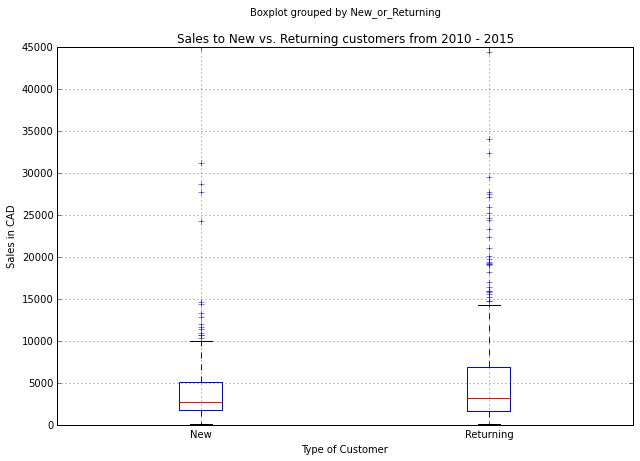

In [186]:
# Creating a boxplot of New versus Returning customer Sales.
Customers_df.boxplot(by = 'New_or_Returning', column='Sales_in_CAD', figsize=(10,7))
plt.ylim(0, 45000)
plt.title('Sales to New vs. Returning customers from 2010 - 2015')
plt.xlabel('Type of Customer')
plt.ylabel('Sales in CAD')


In [187]:
# Getting the columns New or Returning and Sales in CAD with the Date of Order to get 
# the amount of sales over time 
Type_date = Exchange_df[['New_or_Returning', 'Sales_in_CAD']]
Type_date.head()

,New_or_Returning,Sales_in_CAD
Date_of_Order,,
2010-08-04,Returning,1897.60
2010-08-16,Returning,28963.00
2010-08-20,Returning,76339.00
2010-08-27,New,24318.92
2010-09-15,New,35084.00


In [188]:
# Creating a dataframe of just Returning customers
Returning_df = Type_date.groupby(['New_or_Returning']).get_group('Returning ').reset_index()
Returning_df.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-04,Returning,1897.60
1,2010-08-16,Returning,28963.00
2,2010-08-20,Returning,76339.00
3,2010-09-21,Returning,7219.00
4,2010-09-27,Returning,17622.61


In [189]:
# Creating a dataframe of only new customers
New_df = Type_date.groupby(['New_or_Returning']).get_group('New').reset_index()
New_df.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-27,New,24318.92
1,2010-09-15,New,35084.00
2,2010-09-16,New,1563.00
3,2010-09-16,New,1550.00
4,2010-10-06,New,14357.60


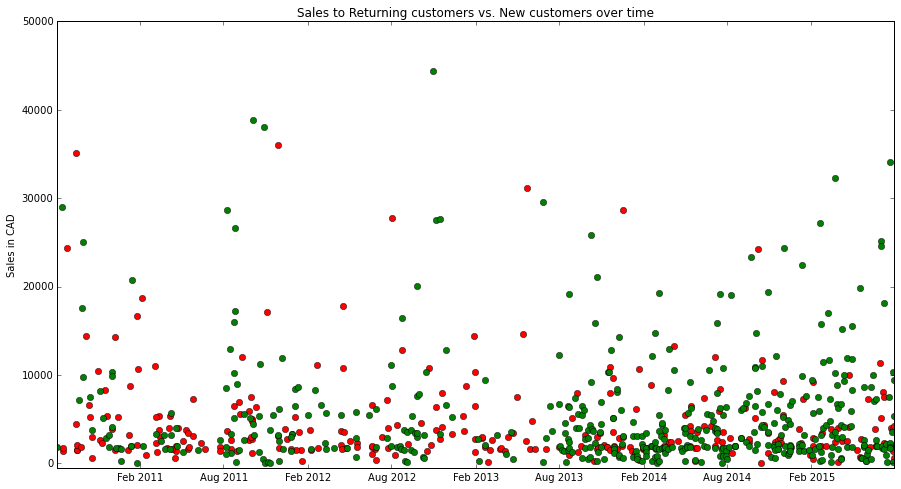

In [197]:
# Making a plot to compare Sales from New and Returning customers over time
plt.figure(figsize = (15,8))
plt.plot(New_df.Date_of_Order, New_df.Sales_in_CAD, 'ro', Returning_df.Date_of_Order, Returning_df.Sales_in_CAD, 'go')
plt.ylim(-500, 50000)

plt.ylabel('Sales in CAD')
plt.title ('Sales to Returning customers vs. New customers over time')

On this data, we can run an unpaired/ student's t - test to see whether sales to new customers and sales to returning customers are significantly different. 

In [209]:
def variance (columnname, n):
    var = std(columnname)**2
    return var

In [227]:
def variance(columnname, n):
    '''assignes function to calculate the 
    standard error of a list or numpy array'''
    mean = sum(columnname)/n                        # creating a variable for the mean of the list/array
    std_part_1 = sum([(num-mean)**2 for num in name]) # creating a variable for the first caclulation of the standard deviation
    var = std_part_1/(n-1)         # Completing the standard deviation calculation 
    return(var)


In [228]:
variance(New_df.Sales_in_CAD, len(New_df.Sales_in_CAD))

92576890.092929989

In [247]:
variance(Returning_df.Sales_in_CAD, len(Returning_df.Sales_in_CAD))

242523522.74525771

In [248]:
# Running the t-test on the variance calculations of the new and returning customers
rvs1 = stats.norm.rvs(loc=92576890.092929989,scale=0.1,size=500)
rvs2 = stats.norm.rvs(loc=242523522.74525771,scale=0.2,size=500)
stats.ttest_ind(rvs1,rvs2)

(-14524809155.641098, 0.0)

The obtained p-value is 0.0, which means that the two variables (New and Returning Customers) are significantly different. This means that there is aboslutely no chance of an outside variable to create the differences between these two variables. 